# BT4222: DNN Backpropagation
We're delving into a classification challenge where the data doesn't allow for linear separation. Our approach involves implementing a two-layer neural network and training it through gradient descent, with the computation of gradients facilitated by the backpropagation algorithm.

In [ ]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid
import math
%matplotlib inline

## Data

This script sets up a function to create a synthetic dataset with a circular pattern, where positive examples are generated within the inner circle and negative examples in the outer circle.

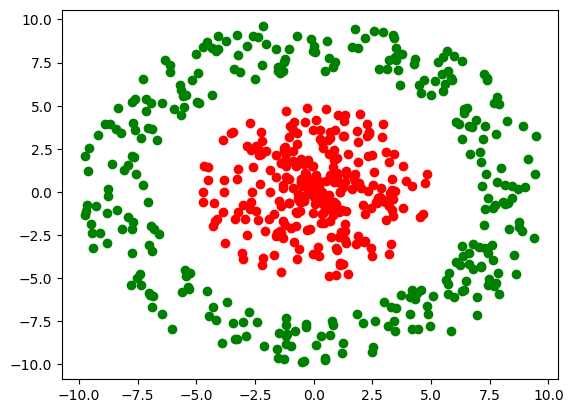

In [ ]:
np.random.seed(0)

def make_dataset(num_points):
    radius = 10
    data = []
    labels = []
    # Generate positive examples (labeled 1).
    for i in range(num_points // 2):
        r = np.random.uniform(0, radius*0.5)
        angle = np.random.uniform(0, 2*math.pi)
        x = r * math.sin(angle)
        y = r * math.cos(angle)
        data.append([x, y])
        labels.append(1)

    # Generate negative examples (labeled 0).
    for i in range(num_points // 2):
        r = np.random.uniform(radius*0.7, radius)
        angle = np.random.uniform(0, 2*math.pi)
        x = r * math.sin(angle)
        y = r * math.cos(angle)
        data.append([x, y])
        labels.append(0)

    data = np.asarray(data)
    labels = np.asarray(labels)
    return data, labels

num_data = 600
data, labels = make_dataset(num_data)

# Note: red indicates a label of 1, green indicates a label of 0
plt.scatter(data[:num_data//2, 0], data[:num_data//2, 1], color='red')
plt.scatter(data[num_data//2:, 0], data[num_data//2:, 1], color='green')

## Neural network structure

Our aim is to employ a neural network to classify this dataset. To reiterate, the objective is to process a two-dimensional vector as input $\mathbf{x} = [x_1, x_2]^T$ and output $\text{Pr}(t = 1 | \mathbf{x})$, where $t$ is the label of the datapoint $\mathbf{x}$.

We will use a neural network with one hidden layer which has three hidden units. The equations describing our neural network are below:

$$\mathbf{g} = \mathbf{U} \mathbf{x} + \mathbf{b}$$
$$\mathbf{h} = \tanh(\mathbf{g})$$
$$z = \mathbf{W} \mathbf{h} + c$$
$$y = \sigma(z)$$

In the equations above, $\mathbf{U} = \begin{pmatrix} u_{11} & u_{12} \\ u_{21} & u_{22} \\  u_{31} & u_{32} \end{pmatrix} \in \mathbb{R}^{3 \times 2}, \mathbf{b} = \begin{pmatrix} b_1  \\ b_2 \\ b_3 \end{pmatrix} \in \mathbb{R}^3, \mathbf{W} = \begin{pmatrix} w_{1} & w_{2} & w_{3} \end{pmatrix} \in \mathbb{R}^{1 \times 3}, c \in \mathbb{R}$ are the parameters of our neural network which we must learn. Notice we are writing $\mathbf{W}$ as a matrix with one row.


## Vectorizing the neural network

We want our neural network to produce predictions for multiple points efficiently. We can do so by vectorizing over training examples. Let  $\mathbf{X} = \begin{pmatrix} x_{11} & x_{12} \\ \vdots   & \vdots  \\  x_{N1} & x_{N2}
\end{pmatrix}$ be a matrix containing $N$ datapoints in separate rows. Then we can vectorize by using:

$$\mathbf{G} = \mathbf{X}\mathbf{U}^T + \mathbf{1}\mathbf{b}^T$$
$$\mathbf{H} = \tanh(\mathbf{G})$$
$$\mathbf{z} =  \mathbf{H}\mathbf{W}^T + \mathbf{1}c$$
$$\mathbf{y} = \sigma(\mathbf{z})$$

$\mathbf{G}$, for example, will store each of the three hidden unit values for each datapoint in each corresponding row.

We can rewrite in scalar form as:
$$g_{ij} = u_{j1} x_{i1} + u_{j2} x_{i2} + b_j$$
$$h_{ij} = \tanh(g_{ij})$$
$$z_{i} = w_1 h_{i1} + w_2 h_{i2} + w_{3} h_{i3} + c$$
$$y_i = \sigma(z_i)$$
Here, $i$ indexes data points and $j$ indexes hidden units, so $i \in \{1, \dots, N\}$ and $j \in \{1, 2, 3\}$.

In [ ]:
# First, initialize our neural network parameters.
params = {}
params['U'] = np.random.randn(3, 2)
params['b'] = np.zeros(3)
params['W'] = np.random.randn(3)
params['c'] = 0

# Notice we make use of numpy's broadcasting when adding the bias b. https://numpy.org/doc/stable/user/basics.broadcasting.html
def forward(X, params):
    G = np.dot(X, params['U'].T)  + params['b']
    H = np.tanh(G)
    z = np.dot(H, params['W'].T) + params['c']
    y = sigmoid(z)

    return y

## Use PyTorch

We make use of automatic differentation software packaged in libraries
such as PyTorch to compute derivatives.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class PyTorchModel(nn.Module):
    def __init__(self):
        super(PyTorchModel, self).__init__()
        self.layer1 = nn.Linear(2, 3)
        self.layer2 = nn.Linear(3, 1)
    def forward(self, X):
        h = torch.tanh(self.layer1(X))
        return self.layer2(h)

In [ ]:
# Convert Data and Labels to PyTorch Tensors
data_tensor = torch.Tensor(data)
labels_tensor = torch.Tensor(labels).float()
labels_tensor = labels_tensor.reshape([600, 1]) # same shape as `y` below

In [ ]:
# Create an instance, define loss function, and Gradient DeScent optimizer
model = PyTorchModel()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=1)

In [ ]:
# A loop involving forward passes, loss computation, backward passes, and optimizer steps to update model parameters
num_steps = 1000
for step in range(num_steps):
  y = model(data_tensor)
  loss = criterion(y, labels_tensor)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  # Print loss every 50 steps
  if step % 50 == 0:
    print("Step {:3d} | Loss {:3.2f}".format(step, float(loss)))


Step   0 | Loss 0.08
Step  50 | Loss 0.16
Step 100 | Loss 0.09
Step 150 | Loss 0.09
Step 200 | Loss 0.09
Step 250 | Loss 0.06
Step 300 | Loss 0.08
Step 350 | Loss 0.10
Step 400 | Loss 0.16
Step 450 | Loss 0.08
Step 500 | Loss 0.15
Step 550 | Loss 0.08
Step 600 | Loss 0.07
Step 650 | Loss 0.07
Step 700 | Loss 0.05
Step 750 | Loss 0.10
Step 800 | Loss 0.09
Step 850 | Loss 0.06
Step 900 | Loss 0.05
Step 950 | Loss 0.05


<ipython-input-24-1cda619951a1>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.pcolormesh(X1, X2, Y, cmap=plt.cm.get_cmap('PuBu'))


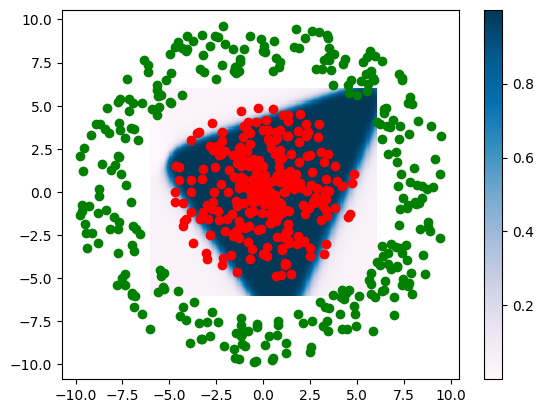

In [ ]:
num_points = 200
x1s = np.linspace(-6.0, 6.0, num_points)
x2s = np.linspace(-6.0, 6.0, num_points)

points = np.transpose([np.tile(x1s, len(x2s)), np.repeat(x2s, len(x1s))])
Y = torch.sigmoid(model(torch.Tensor(points)))
Y = Y.detach().numpy() # convert to numpy
Y = Y.reshape(num_points, num_points)
X1, X2 = np.meshgrid(x1s, x2s)

plt.pcolormesh(X1, X2, Y, cmap=plt.cm.get_cmap('PuBu'))
plt.colorbar()
plt.scatter(data[:num_data//2, 0], data[:num_data//2, 1], color='red')
plt.scatter(data[num_data//2:, 0], data[num_data//2:, 1], color='green')